In [1]:
## import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, RocCurveDisplay

In [2]:
## import du jeu de données
data = pd.read_csv('social_media_viral_content_dataset.csv')
data.head()

,post_id,platform,content_type,topic,language,region,post_datetime,hashtags,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
0,SM_100000,Instagram,text,Sports,ur,UK,2024-12-10 00:00:00,#tech #funny #music,2319102,122058,15800,861,0.0598,0.464,1
1,SM_100001,Instagram,carousel,Sports,ur,Brazil,2024-10-13 00:00:00,#news #fyp #funny #ai #trending,2538464,110368,11289,54887,0.0695,-0.800,1
2,SM_100002,YouTube Shorts,video,Technology,ur,UK,2024-05-03 00:00:00,#ai #news,1051176,87598,47196,44132,0.1702,0.416,0
3,SM_100003,X,text,Politics,ur,US,2024-08-04 00:00:00,#ai #funny,5271440,329465,774,59736,0.0740,0.877,1
4,SM_100004,YouTube Shorts,text,Education,es,US,2024-03-28 00:00:00,#news #ai #viral #funny #fyp,3186256,199141,5316,83105,0.0903,0.223,1


In [3]:
print('Info sur les données:')
data.info()
print('\nValeurs manquantes:')
print(data.isna().sum())
print('\nDoublons:')
print(data.duplicated().value_counts())
print('\nDistribution de la Target:')
print(data['is_viral'].value_counts())

Info sur les données:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          2000 non-null   object 
 1   platform         2000 non-null   object 
 2   content_type     2000 non-null   object 
 3   topic            2000 non-null   object 
 4   language         2000 non-null   object 
 5   region           2000 non-null   object 
 6   post_datetime    2000 non-null   object 
 7   hashtags         2000 non-null   object 
 8   views            2000 non-null   int64  
 9   likes            2000 non-null   int64  
 10  comments         2000 non-null   int64  
 11  shares           2000 non-null   int64  
 12  engagement_rate  2000 non-null   float64
 13  sentiment_score  2000 non-null   float64
 14  is_viral         2000 non-null   int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 234.5+ KB

Valeurs manquantes:
post

In [4]:
#Statistique descriptive
data.describe()


,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4.284860e+06,245329.244000,24786.929000,49936.981500,0.157852,-0.000566,0.699000
std,3.246193e+06,145032.423582,14433.288364,29012.818697,0.535457,0.574911,0.458807
min,4.380000e+03,292.000000,14.000000,127.000000,0.035700,-1.000000,0.000000
25%,1.652742e+06,118903.750000,12337.750000,25698.750000,0.057975,-0.507000,0.000000
50%,3.469408e+06,239831.000000,24519.500000,50212.000000,0.084500,0.001000,1.000000
75%,6.348078e+06,372323.500000,37116.250000,75433.000000,0.142525,0.495250,1.000000
max,1.437179e+07,499983.000000,49989.000000,99977.000000,12.573200,0.999000,1.000000


<Axes: >

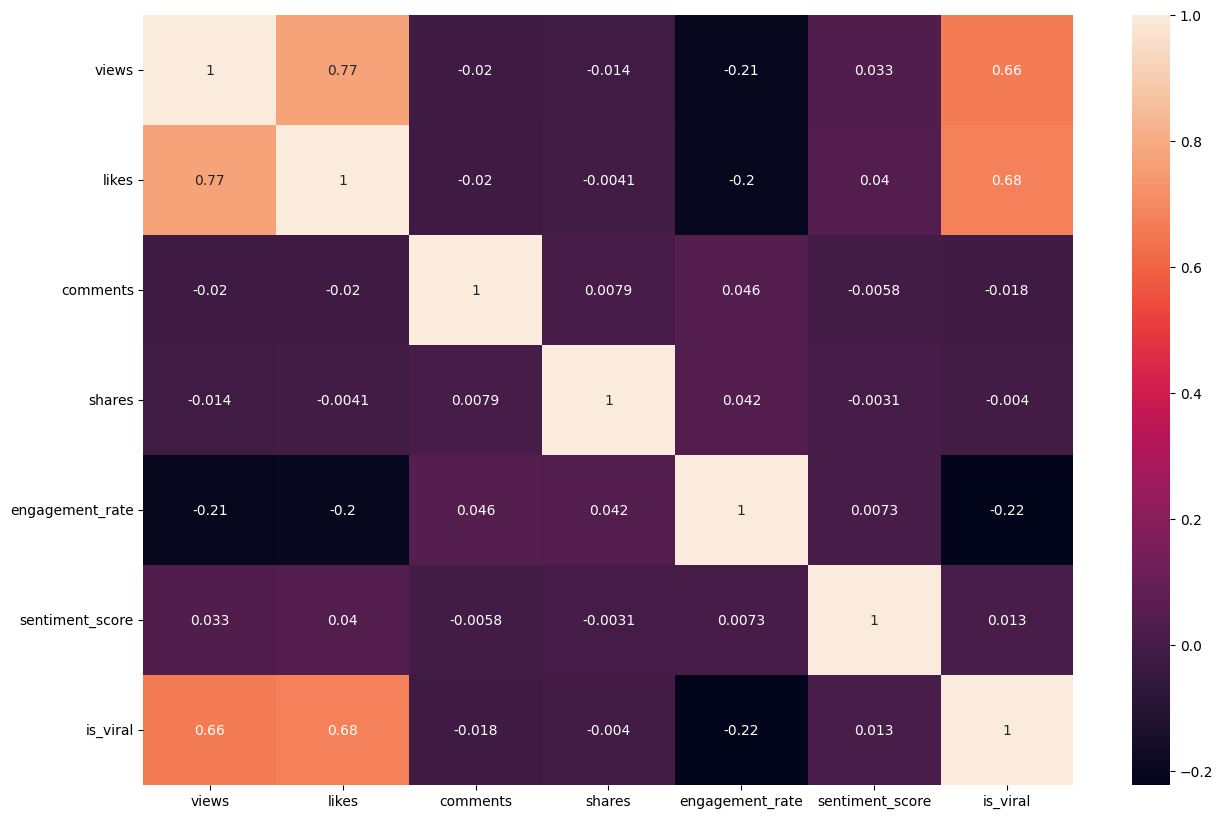

In [5]:
#Matrice de correlation
plt.figure(figsize=(15,10))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True)

In [6]:
#Nombre de valeurs distinctes dans la colonne post_id
# print(data['post_id'].nunique())

#suppression des colonnes inutiles
data = data.drop('post_id', axis=1)
# Nous avons pris la forte correlation à partir de 0.80, raison pour laquelle aucun des colonnes views et likes n'a été supprimée.
#il n'y a ni de valeurs manquantes, ni de doublons.


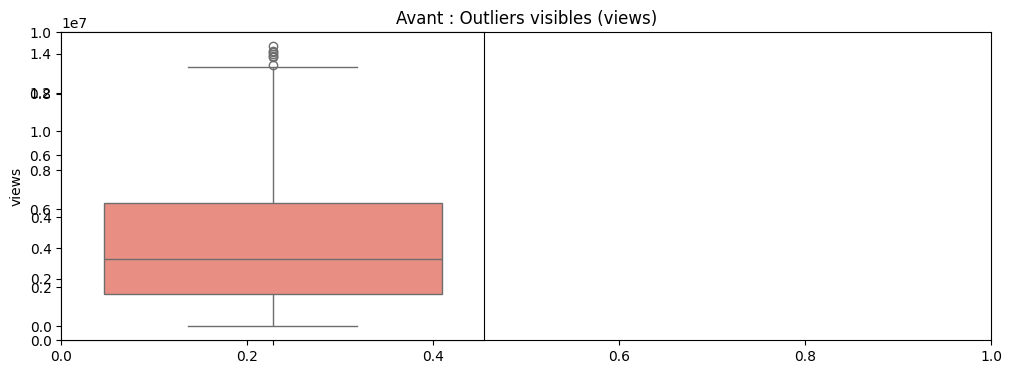

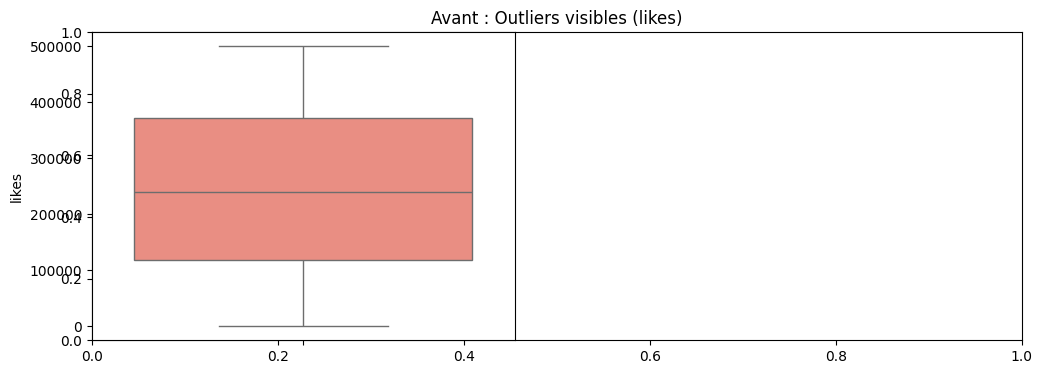

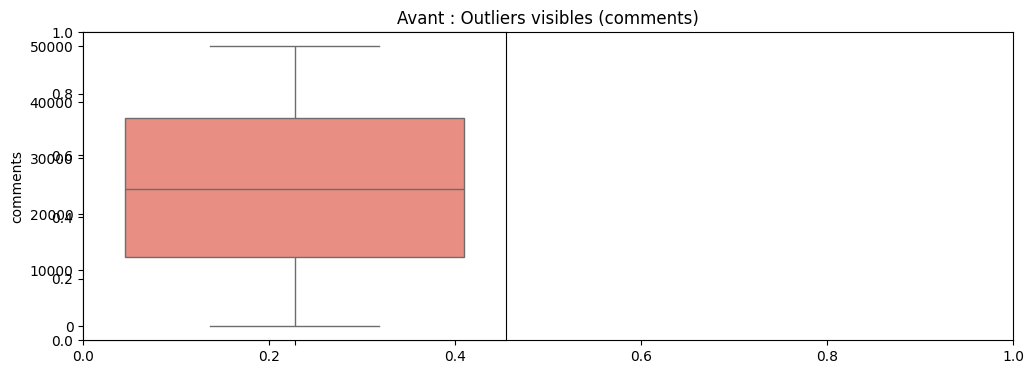

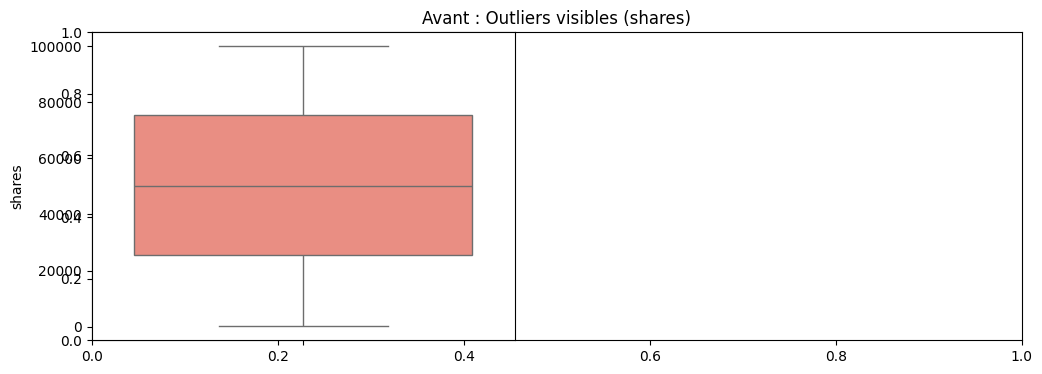

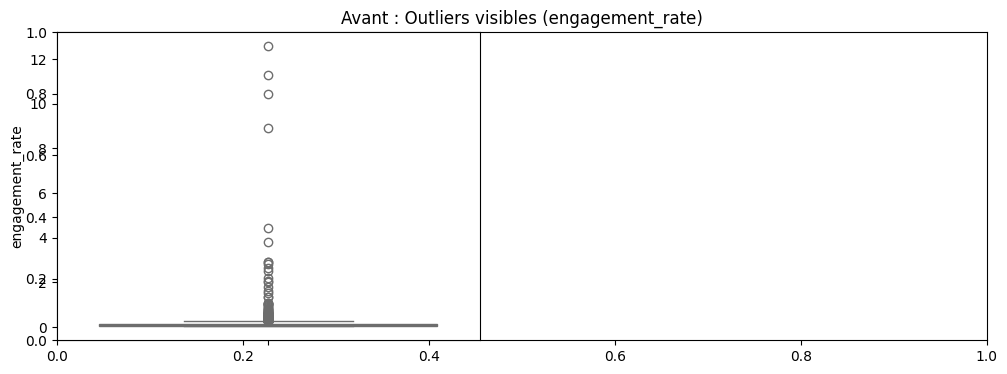

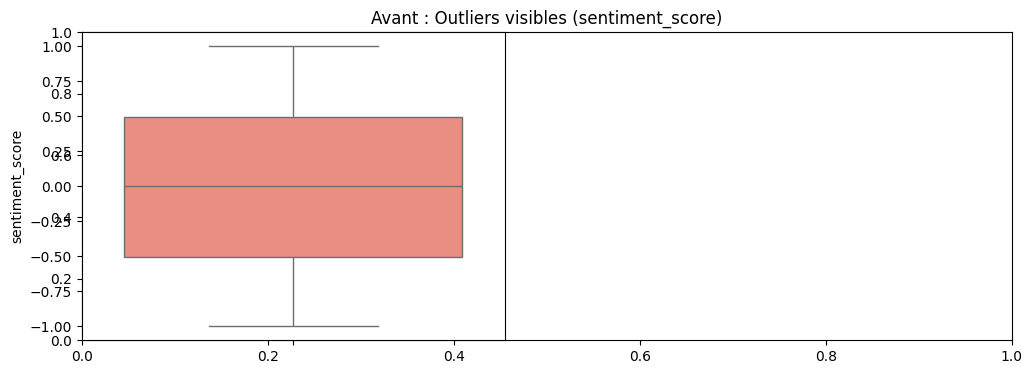

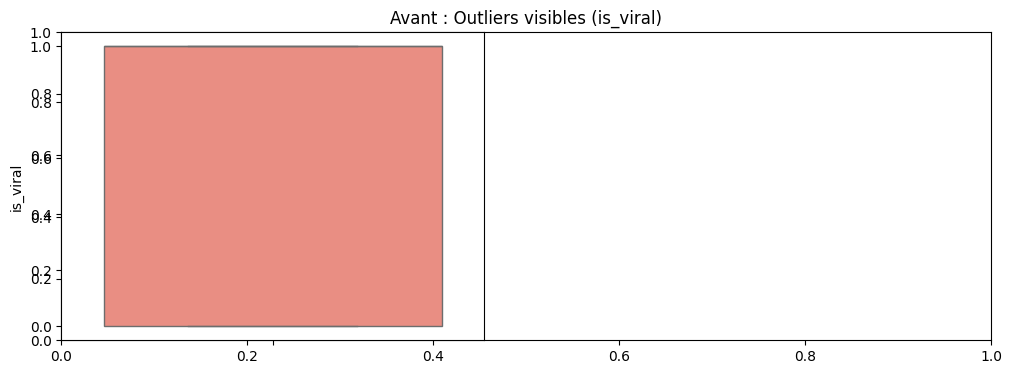

In [7]:
#Boxplot de chaque variable afin de détecter les outliers
for col in data.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(12, 4))
    plt.title('Avant : Outliers visibles ('+ col +')')
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], color="salmon")

In [8]:
#Traitement des outliers
# Fonction pour détecter et remplacer les valeurs aberrantes avec les Bounds
def replace_outliers(df):
    for col in df.select_dtypes(include=['number']).columns:  # On traite seulement les variables de type numérique
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

replace_outliers(data)               

In [9]:
#Encodage des variables catégorielles
categorical_cols = data.select_dtypes(include=['object']).columns

for col in categorical_cols:
    fe = data.groupby(col).size()/len(data)
    data[f"{col}_freq_encode"] = data[col].map(fe)
    data = data.drop(col, axis=1)
data.head()

,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral,platform_freq_encode,content_type_freq_encode,topic_freq_encode,language_freq_encode,region_freq_encode,post_datetime_freq_encode,hashtags_freq_encode
0,2319102.0,122058.0,15800.0,861.0,0.0598,0.464,1.0,0.2695,0.244,0.1650,0.2025,0.1925,0.0035,0.0005
1,2538464.0,110368.0,11289.0,54887.0,0.0695,-0.800,1.0,0.2695,0.264,0.1650,0.2025,0.2010,0.0045,0.0005
2,1051176.0,87598.0,47196.0,44132.0,0.1702,0.416,0.0,0.2495,0.236,0.1655,0.2025,0.1925,0.0030,0.0040
3,5271440.0,329465.0,774.0,59736.0,0.0740,0.877,1.0,0.2425,0.244,0.1660,0.2025,0.2140,0.0025,0.0050
4,3186256.0,199141.0,5316.0,83105.0,0.0903,0.223,1.0,0.2495,0.244,0.1735,0.1895,0.2140,0.0035,0.0005


In [10]:
#Sélection des variables indépendates et de la variable dépendante
X = data.drop('is_viral', axis=1)
y = data['is_viral']

In [11]:
#On applique pas d'ACP ici, car non seulement le nombre de variable n'est pas très grand et aussi il n y a pas de forte correlation entre elles.
#Division des données en celles de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
#Normalisation des données
print('Standardisation des features...')
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_train_sc

Standardisation des features...


array([[-0.33276842,  0.14126623,  1.59552282, ...,  0.07239104,
         0.16725365,  2.45169537],
       [ 1.43565147,  0.96991382, -0.24634393, ...,  0.07239104,
        -0.97962854, -0.68000253],
       [ 0.60378671,  0.4463372 ,  1.64416415, ...,  0.3019761 ,
         0.54954772, -0.68000253],
       ...,
       [-1.18688187, -1.47525368,  0.8666639 , ...,  0.07239104,
         1.69642991,  2.71267019],
       [-0.33244186, -0.31727746, -1.3659941 , ...,  1.56469392,
         0.16725365, -0.68000253],
       [ 0.1741826 ,  1.3311848 , -0.01434621, ...,  0.3019761 ,
        -0.59733448, -0.68000253]], shape=(1600, 13))

In [13]:
#Utilisation du modèle RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_sc, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<Axes: >

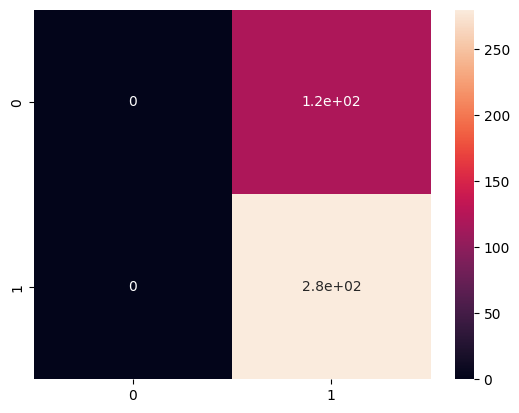

In [14]:
#Evaluation du modèle
#matrice de confusion
#y_predict_train = classifier.predict(X_train_sc)
y_predict_test = classifier.predict(X_test)
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)
cm1 = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm1, annot=True)

In [15]:
#Classification report
#print(classification_report(y_train, y_predict_train))
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       120
         1.0       0.70      1.00      0.82       280

    accuracy                           0.70       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.49      0.70      0.58       400



c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

In [16]:
#Cross Validation
accuracies = cross_val_score(classifier, X_train_sc, y_train, cv=10)
print('Cross Val accuracies', accuracies)

Cross Val accuracies [0.99375 1.      1.      1.      1.      1.      1.      0.99375 1.
 1.     ]


In [17]:
# Optimisation du modèle RandomForest
param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(classifier, param, cv=5, n_jobs=-1, verbose=1)

print('Optimisation en cours...')
grid_search.fit(X_train_sc, y_train)

print(f'Meilleurs paramètres: {grid_search.best_params_}')
print(f'Meilleur score: {grid_search.best_score_}')


Optimisation en cours...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Meilleur score: 0.999375


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       120
         1.0       0.70      1.00      0.82       280

    accuracy                           0.70       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.49      0.70      0.58       400



c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\

<Axes: >

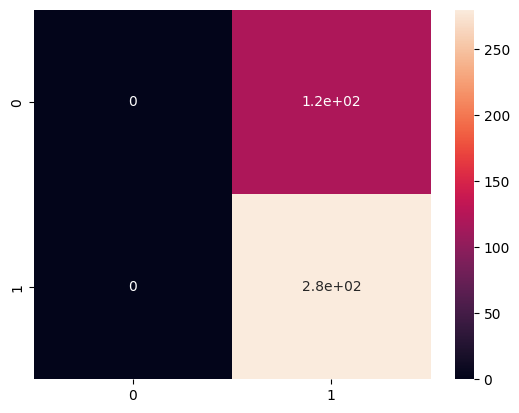

In [18]:
#Modèle final optimisé
best_rf = grid_search.best_estimator_

#prédictions
y_pred = best_rf.predict(X_test)

#Evaluation
#classification report
print(classification_report(y_test, y_pred))
#matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

c:\Users\TCHAMGOUE Yann\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


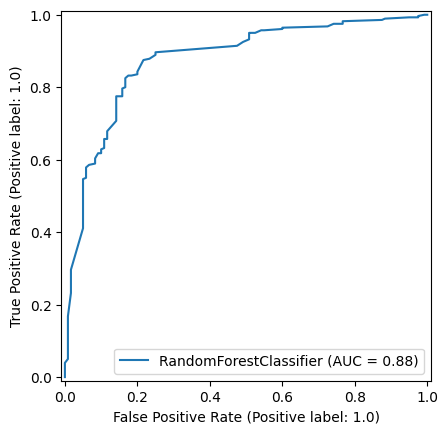

In [19]:
#Courbe ROC et AUC
#RocCurveDisplay.from_estimator(best_rf, X_train_sc, y_train)
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)

In [21]:
# Sauvegarde du modèle
import pickle
pickle.dump(best_rf, open('brfSNZ.pkl','wb'))